QUORA QUESTION PAIR

Business Proble:


*   identify the pair of question are duplicates or not asked in the quora.

Business constraints:


*   should be low misclassification
*   need probability of two questions are duplicates or not
*   no letency requirement
*   interpretibility is partialy required

Machine learning problem:


*   train.csv: qid1, qid2, question1, question2, is_duplicate
*   Binary classification problem
*   performance metrics: log loss, confusion matrix
*   train, test split: random split















In [ ]:
#import necessary libararis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy

EDA and statistics

In [ ]:
#importing dataset
data = pd.read_csv('/content/drive/My Drive/quora question pair/train.csv')

In [ ]:
data.shape
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
#taking only 100k datapoints and balencing 0 and 1
data_positive = data[data['is_duplicate'] == 1].sample(n=50000)
data_negative = data[data['is_duplicate'] == 0].sample(n=50000)
data = pd.concat([data_negative, data_positive]).reset_index()
data.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,17784,17784,33743,33744,How does Brexit affect India in employment of ...,How do I assign a default value to all cells u...,0
1,59763,59763,104630,4862,How do I earn money through Quora?,How can I use Quora to make money?,0
2,97006,97006,129892,161478,Is beard oil effective?,Is using beard oil harmful to skin?,0
3,18025,18025,34174,34175,What is May trying to achieve by talking to EU...,What would you do if you became rich (really r...,0
4,393071,393071,525823,525824,I hate taking a bath and shaving. What should ...,What is it like to take bath with a girl?,0


In [ ]:
data.isnull().sum()

index           0
id              0
qid1            0
qid2            0
question1       1
question2       0
is_duplicate    0
dtype: int64

In [ ]:
data.shape

(100000, 7)

In [ ]:
data.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,17784,17784,33743,33744,How does Brexit affect India in employment of ...,How do I assign a default value to all cells u...,0
1,59763,59763,104630,4862,How do I earn money through Quora?,How can I use Quora to make money?,0
2,97006,97006,129892,161478,Is beard oil effective?,Is using beard oil harmful to skin?,0
3,18025,18025,34174,34175,What is May trying to achieve by talking to EU...,What would you do if you became rich (really r...,0
4,393071,393071,525823,525824,I hate taking a bath and shaving. What should ...,What is it like to take bath with a girl?,0


In [ ]:
data[data.isnull().any(1)]

,index,id,qid1,qid2,question1,question2,is_duplicate
12719,363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         100000 non-null  int64 
 1   id            100000 non-null  int64 
 2   qid1          100000 non-null  int64 
 3   qid2          100000 non-null  int64 
 4   question1     99999 non-null   object
 5   question2     100000 non-null  object
 6   is_duplicate  100000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.3+ MB


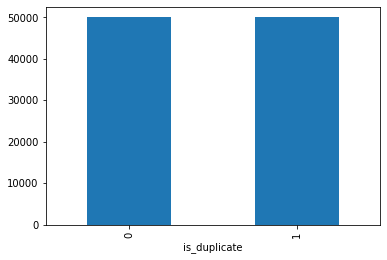

In [ ]:
data.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
per = (data.groupby('is_duplicate')['id'].count()*100)/data.shape[0]
print('duplicate questions pair %:', per[0])
print('similar questions pair %', per[1])

duplicate questions pair %: 50.0
similar questions pair % 50.0


In [ ]:
qids = data['qid1'].tolist() + data['qid2'].tolist()
unique_que = len(np.unique(qids))
qids = pd.Series(qids)
repeates = np.sum(qids.value_counts()>1)
print('total no of questions:', len(qids))
print('total no of repeated questions', repeates)

total no of questions: 200000
total no of repeated questions 21544


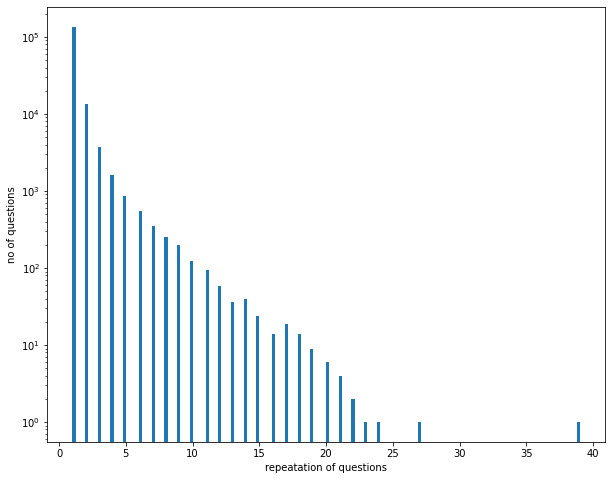

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.xlabel('repeatation of questions')
plt.ylabel('no of questions')
plt.show()

In [ ]:
#filing nan values with ''(space)
data = data.fillna('')


In [ ]:
data.isnull().sum()

index           0
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

Feature extraction:

*   frequency of qid1
*   frequency of qid2
*   length of question1
*   length of question2
*   no of words in questions1
*   no of words in questions2
*   no of common unique words in question1 and questions2
*   total no of words in questions1 + total no of words in questions2
*   word share(common words in questions1 and questions 2)/total words
*   sum of frequency of qid1 and qid2
*   difference of frequency of qid1 and qid2

In [ ]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')

In [ ]:
data['q1len'] = data['question1'].str.len()
data['q2len'] = data['question2'].str.len()

In [ ]:
data['q1word'] = data['question1'].apply(lambda x : len(x.split(' ')))
data['q2word'] = data['question2'].apply(lambda x : len(x.split(' ')))

In [ ]:
def normalized_word_Common(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2)# len(w1 & w2) returns common in w1 and w2
data['common_word'] = data.apply(normalized_word_Common, axis=1)

In [ ]:
def normalized_word_Total(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * (len(w1) + len(w2))
data['total_word'] = data.apply(normalized_word_Total, axis=1)

In [ ]:
def normalized_word_share(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1) 

In [ ]:
data['total_freq'] = data['freq_qid1'] + data['freq_qid2']
data['difference_freq'] = abs(data['freq_qid1'] - data['freq_qid2'])

In [ ]:
data.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1word,q2word,common_word,total_word,word_share,total_freq,difference_freq
0,17784,17784,33743,33744,How does Brexit affect India in employment of ...,How do I assign a default value to all cells u...,0,1,1,67,68,10,14,1.0,23.0,0.043478,2,0
1,59763,59763,104630,4862,How do I earn money through Quora?,How can I use Quora to make money?,0,1,2,34,34,7,8,2.0,15.0,0.133333,3,1
2,97006,97006,129892,161478,Is beard oil effective?,Is using beard oil harmful to skin?,0,2,1,23,35,4,7,3.0,11.0,0.272727,3,1
3,18025,18025,34174,34175,What is May trying to achieve by talking to EU...,What would you do if you became rich (really r...,0,1,1,103,273,17,57,4.0,57.0,0.070175,2,0
4,393071,393071,525823,525824,I hate taking a bath and shaving. What should ...,What is it like to take bath with a girl?,0,1,1,51,41,11,10,3.0,20.0,0.150000,2,0


In [ ]:
print('minimum no of words in question1:', data['q1word'].min())
print('minimum no of words in question2:', data['q2word'].min())
print('no of words contains minimum no of words in question1:', data[data['q1word'] == data['q1word'].min()].shape[0])
print('no of words contains minimum no of words in question2:', data[data['q2word'] == data['q2word'].min()].shape[0])

minimum no of words in question1: 1
minimum no of words in question2: 1
no of words contains minimum no of words in question1: 13
no of words contains minimum no of words in question2: 3


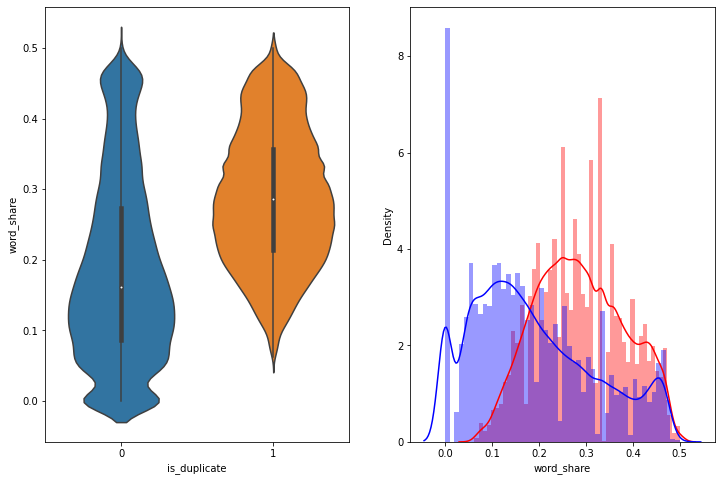

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color ='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color= 'blue' )
plt.show()

In [ ]:
#obervations:
#share words are also important features
#share word for class o and class 1 are not perfectly separable

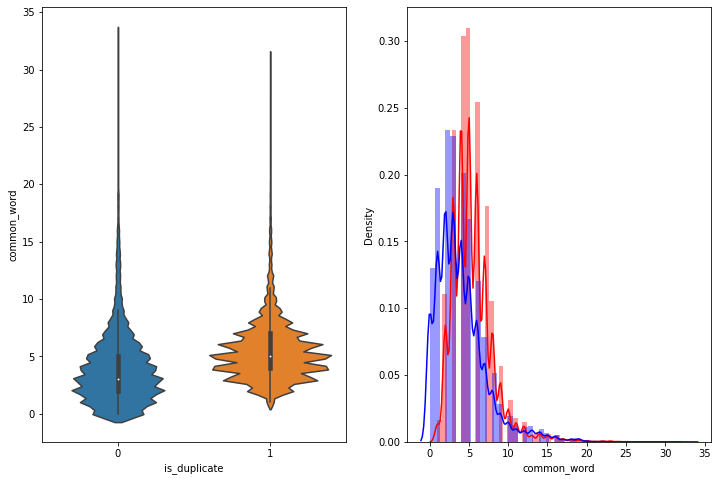

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_word', data = data[0:])
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['common_word'][0:] , label = "1", color= 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['common_word'][0:] , label = "0" , color= 'blue' )
plt.show()

Text preprocessing(cleanning):


*   removing html
*   removing punctuation
*   removing stop words
*   converting to lowercase
*   performing stemming








In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
stop = set(stopwords.words('english'))
snow = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def cleanning(sent):
  sentence = []
  #remove html
  html_free = re.sub('<.*?>', ' ', sent)
  #remove punctuations
  punc_free =  re.sub(r'[^A-Za-z0-9+.\-]+', ' ', html_free)
  for word in punc_free.split():
    if len(word)>1:
      word = word.lower()
      if word not in stop:
        s = snow.stem(word)
        sentence.append(s)
  return (' '.join(sentence))      




In [ ]:
clean_q1 = data['question1'].apply(cleanning)

In [ ]:
clean_q2 = data['question2'].apply(cleanning)

ADVANCE FEATURIZATION:
*   CWC_Min : Ratio of common_word_count to min length of word count of Q1 and Q2
*   CWC_Max : Ratio of common_word_count to max length of word count of Q1 and Q2
*   Last_Word_Equality : Check if last word of both questions is equal or not
*   First_Word_Equality : Check if First word of both questions is equal or not
*   Abs_Len_Diff : Abs. length difference
*   Mean_Len : Average Token Length of both Questions
*   Fuzz_Ratio
*   Fuzz_Partial_Ratio
*   Token_Sort_Ratio
*   Token_Set_Ratio
*   Longest_Substr_Ratio : Ratio of length of longest common substring to min length of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))









In [ ]:
#installing fuzzywuzzy
!pip install requests fuzzywuzzy pandas pyjstat numpy plotly matplotlib seaborn geopy google folium pandas googlemaps

In [ ]:
from fuzzywuzzy import fuzz

In [ ]:
#function to add new advance features
SAFE_DIV = 0.0001
def createFeatures(ques1, ques2):
  featureValues = [0.0]*10
  question1_words = ques1.split()
  question2_words = ques2.split()
  if len(question1_words) == 0 or len(question2_words) == 0:
    return featureValues
  ques1_words_set = set(ques1.split())
  ques2_words_set = set(ques2.split())
  featureValues[0] = len(ques1_words_set.intersection(ques2_words_set)) / (min(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
  featureValues[1] = len(ques1_words_set.intersection(ques2_words_set)) / (max(len(ques1_words_set), len(ques2_words_set)) + SAFE_DIV)
  featureValues[2] = int(question1_words[-1] == question2_words[-1])
  featureValues[3] = int(question1_words[0] == question2_words[0])
  featureValues[4] = abs(len(question1_words) - len(question2_words))
  featureValues[5] = (len(question1_words) + len(question2_words))/2
  featureValues[6] = fuzz.partial_ratio(ques1, ques2)
  featureValues[7] = fuzz.partial_ratio(ques1, ques2)
  featureValues[8] = fuzz.token_sort_ratio(ques1, ques2)
  featureValues[9] = fuzz.token_set_ratio(ques1, ques2)   
  return featureValues
  

In [ ]:
advFeatures = data.apply(lambda x : createFeatures(x['question1'], x['question2']), axis=1)

In [ ]:
data["CWC_Min"] = list(map(lambda x: x[0], advFeatures))
data["CWC_Max"] = list(map(lambda x: x[1], advFeatures))
data["Last_Word_Equality"] = list(map(lambda x: x[2], advFeatures))
data["First_Word_Equality"] = list(map(lambda x: x[3], advFeatures))
data["Abs_Len_Diff"] = list(map(lambda x: x[4], advFeatures))
data["Mean_Len"] = list(map(lambda x: x[5], advFeatures))
data["Fuzz_Ratio"] = list(map(lambda x: x[6], advFeatures))
data["Fuzz_Partial_Ratio"] = list(map(lambda x: x[7], advFeatures))
data["Token_Sort_Ratio"] = list(map(lambda x: x[8], advFeatures))
data["Token_Set_Ratio"] = list(map(lambda x: x[9], advFeatures))

data = data.fillna("")

In [ ]:
data.shape

(100000, 28)

In [ ]:
data.head(3)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1word,q2word,common_word,total_word,word_share,total_freq,difference_freq,CWC_Min,CWC_Max,Last_Word_Equality,First_Word_Equality,Abs_Len_Diff,Mean_Len,Fuzz_Ratio,Fuzz_Partial_Ratio,Token_Sort_Ratio,Token_Set_Ratio
0,17784,17784,33743,33744,How does Brexit affect India in employment of ...,How do I assign a default value to all cells u...,0,1,1,67,68,10,14,1.0,23.0,0.043478,2,0,0.099999,0.076922,0.0,1.0,4.0,12.0,33.0,33.0,27.0,29.0
1,59763,59763,104630,4862,How do I earn money through Quora?,How can I use Quora to make money?,0,1,2,34,34,7,8,2.0,15.0,0.133333,3,1,0.285710,0.249997,0.0,1.0,1.0,7.5,47.0,47.0,73.0,68.0
2,97006,97006,129892,161478,Is beard oil effective?,Is using beard oil harmful to skin?,0,2,1,23,35,4,7,3.0,11.0,0.272727,3,1,0.749981,0.428565,0.0,1.0,3.0,5.5,57.0,57.0,50.0,71.0


In [ ]:
data.isnull().sum()

index                  0
id                     0
qid1                   0
qid2                   0
question1              0
question2              0
is_duplicate           0
freq_qid1              0
freq_qid2              0
q1len                  0
q2len                  0
q1word                 0
q2word                 0
common_word            0
total_word             0
word_share             0
total_freq             0
difference_freq        0
CWC_Min                0
CWC_Max                0
Last_Word_Equality     0
First_Word_Equality    0
Abs_Len_Diff           0
Mean_Len               0
Fuzz_Ratio             0
Fuzz_Partial_Ratio     0
Token_Sort_Ratio       0
Token_Set_Ratio        0
dtype: int64

In [ ]:
data['is_duplicate'].value_counts()

1    50000
0    50000
Name: is_duplicate, dtype: int64

In [ ]:
import collections
from wordcloud import WordCloud, STOPWORDS
stopword = set(STOPWORDS)

In [ ]:
#plotting words in word cloud for duplicate data(1)
ls1 = data[data['is_duplicate']==1]['question1'].tolist()
ls2 = data[data['is_duplicate'] == 1]['question2'].tolist()
ls = ls1 + ls2
words = []
for q in ls:
  for word in q.split():
    words.append(word)


In [ ]:
freq_word = dict(collections.Counter(words))

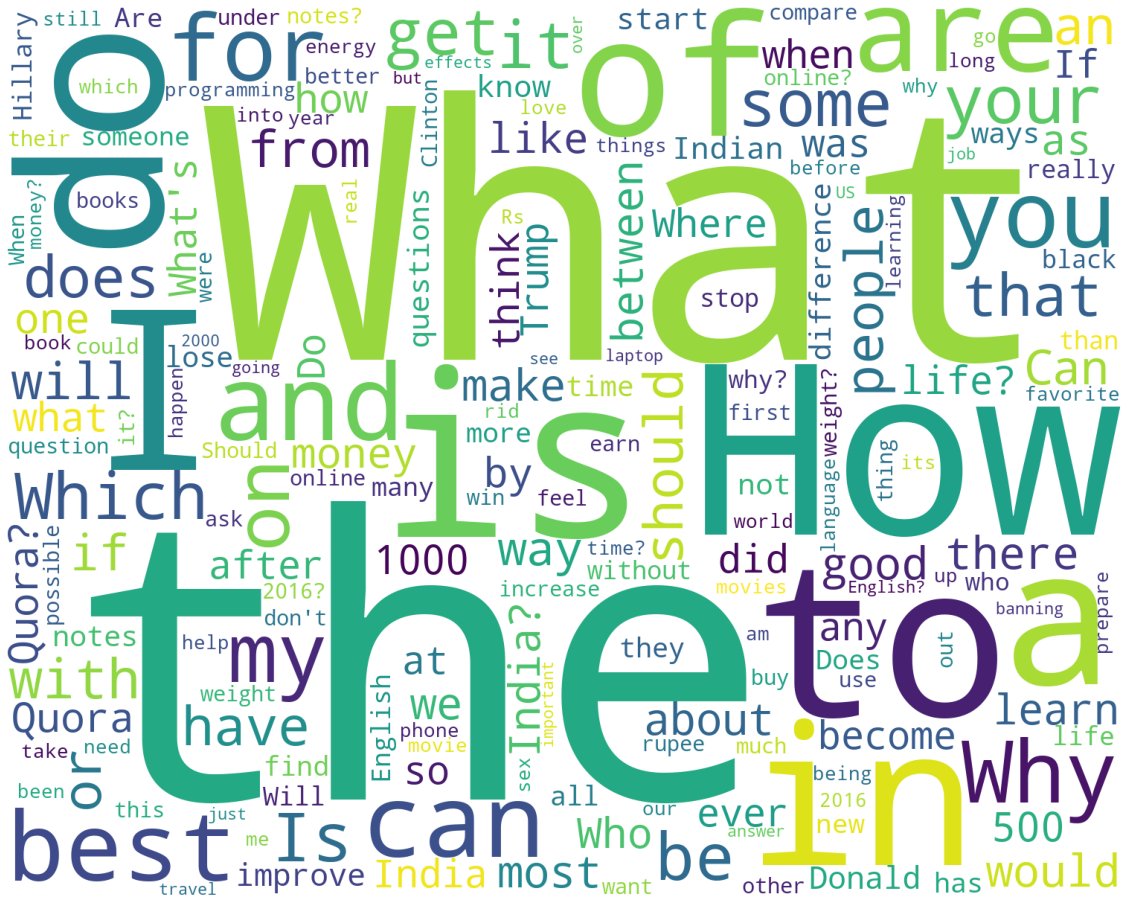

In [ ]:
word_cloud = WordCloud(width=1500, height=1200, background_color='white', stopwords=stopword)
word_cloud.generate_from_frequencies(frequencies=freq_word)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
#for non duplicate(0)
#plotting words in word cloud for duplicate data(1)
ls1 = data[data['is_duplicate']==0]['question1'].tolist()
ls2 = data[data['is_duplicate'] == 0]['question2'].tolist()
ls = ls1 + ls2
words = []
for q in ls:
  for word in q.split():
    words.append(word)

In [ ]:
freq_word = dict(collections.Counter(words))

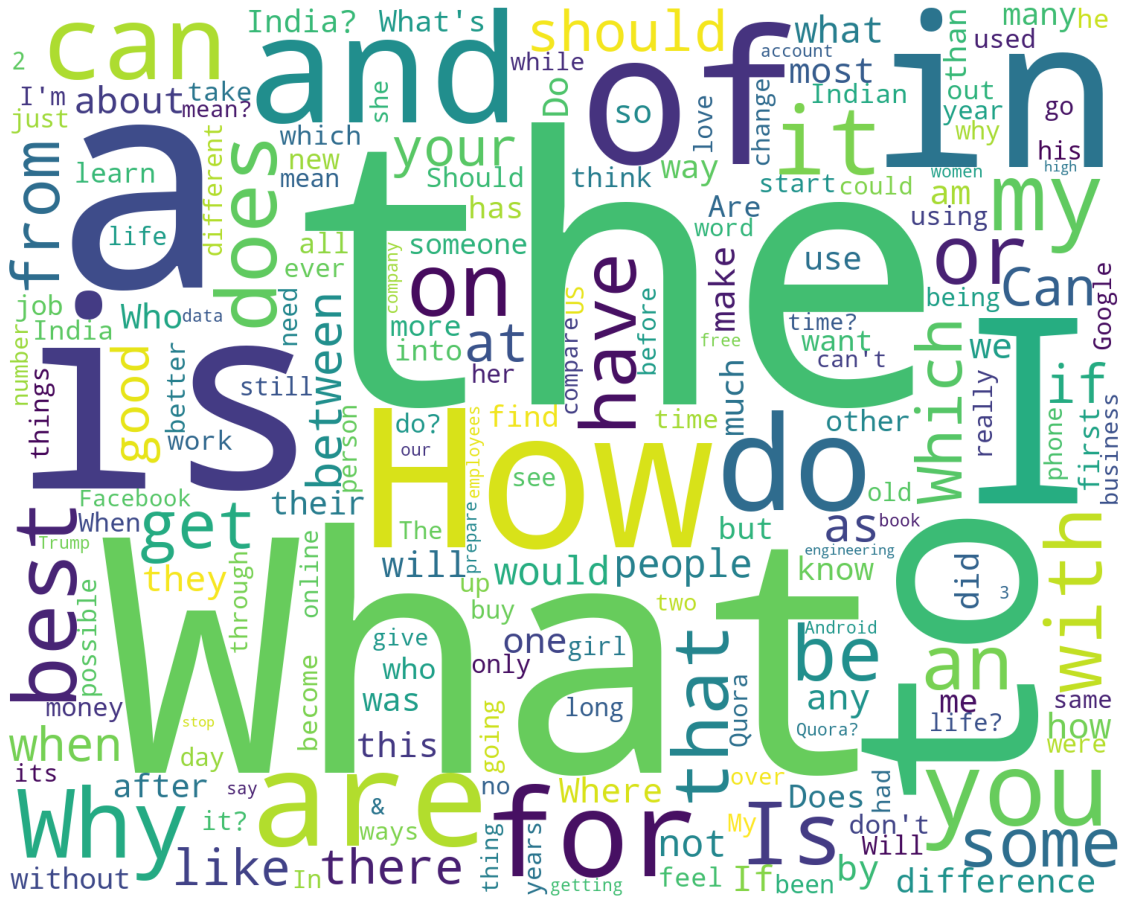

In [ ]:
word_cloud = WordCloud(width=1500, height=1200, background_color='white', stopwords=stopword)
word_cloud.generate_from_frequencies(frequencies=freq_word)
plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [ ]:
data.columns


Index(['index', 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1word', 'q2word',
       'common_word', 'total_word', 'word_share', 'total_freq',
       'difference_freq', 'CWC_Min', 'CWC_Max', 'Last_Word_Equality',
       'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len', 'Fuzz_Ratio',
       'Fuzz_Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio'],
      dtype='object')

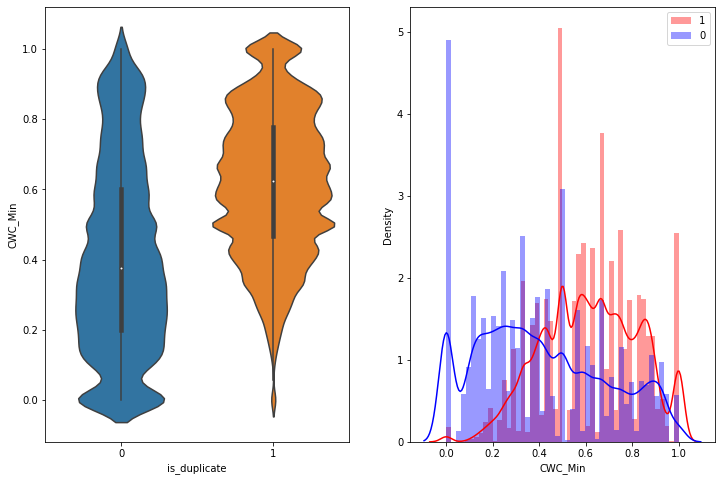

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'CWC_Min', data = data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['CWC_Min'][0:] , label = "1", color ='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['CWC_Min'][0:] , label = "0" , color='blue' )
plt.legend()
plt.show()

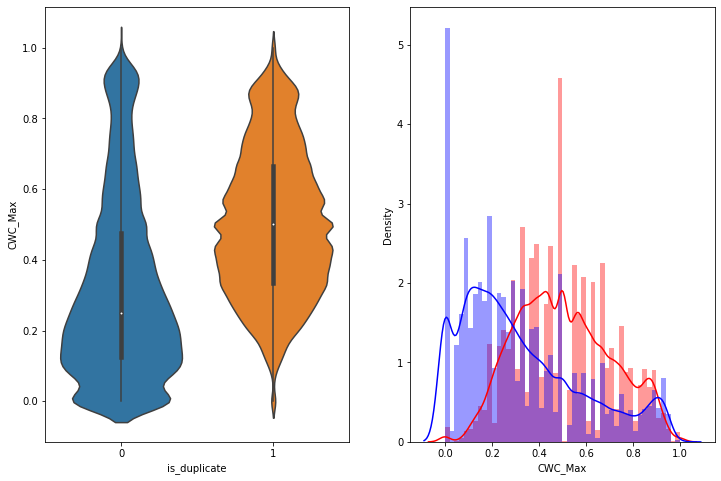

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='CWC_Max', data=data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['CWC_Max'], color='red')
sns.distplot(data[data['is_duplicate']==0]['CWC_Max'], color='blue')
plt.show()

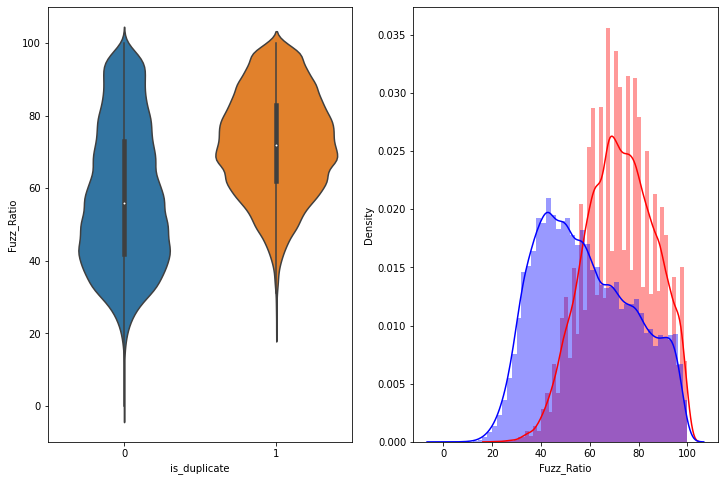

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='Fuzz_Ratio', data=data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['Fuzz_Ratio'], color='red')
sns.distplot(data[data['is_duplicate']==0]['Fuzz_Ratio'], color='blue')
plt.show()

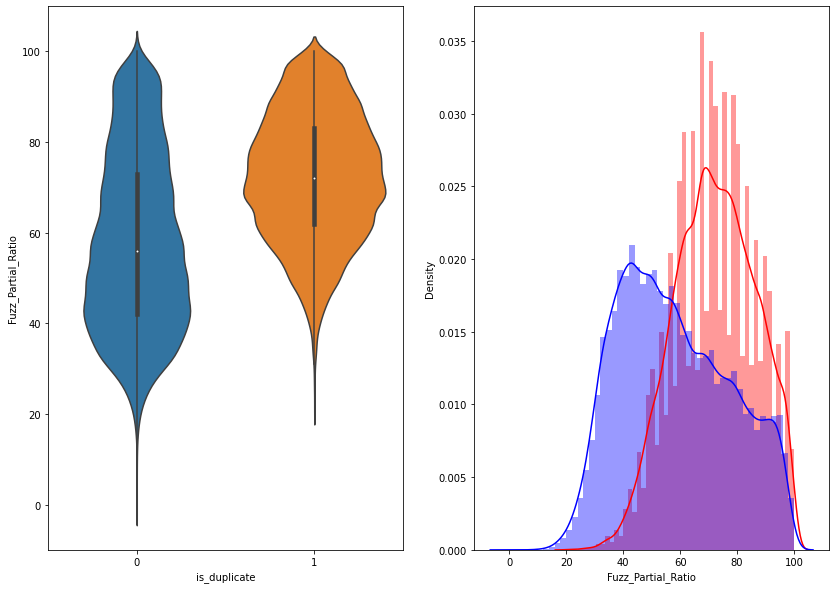

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='Fuzz_Partial_Ratio', data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['Fuzz_Partial_Ratio'], color='red')
sns.distplot(data[data['is_duplicate']==0]['Fuzz_Partial_Ratio'], color='blue')
plt.show()

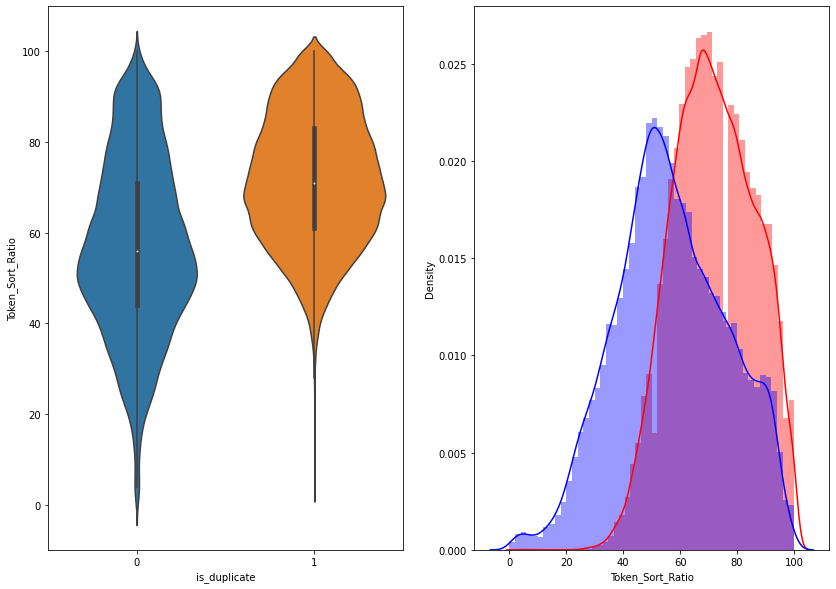

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='Token_Sort_Ratio', data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['Token_Sort_Ratio'], color='red')
sns.distplot(data[data['is_duplicate']==0]['Token_Sort_Ratio'], color='blue')
plt.show()

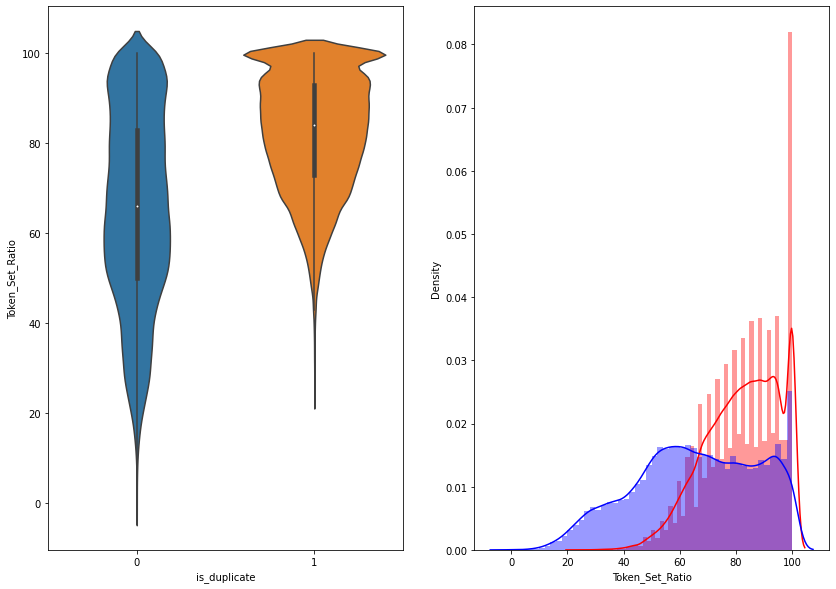

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='Token_Set_Ratio', data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1]['Token_Set_Ratio'], color='red')
sns.distplot(data[data['is_duplicate']==0]['Token_Set_Ratio'], color='blue')
plt.show()

In [ ]:
#data visualization with tsne
tsne = data.drop(['question1', 'question2','index', 'id'], axis=1).sample(n=5000)
lable = tsne['is_duplicate']
tsne_data = tsne.drop(['is_duplicate'], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std_data = std.fit_transform(tsne_data)

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components = 2)
tsne_data1 = tsne_model.fit_transform(std_data)

In [ ]:
new_data = np.vstack((tsne_data1.T, lable)).T

In [ ]:
final_tsne = pd.DataFrame(data=new_data, columns=('dim1', 'dim2', 'is_duplicate'))

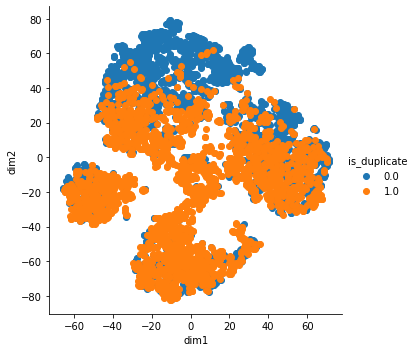

In [ ]:
sns.FacetGrid(data=final_tsne, height=5, hue='is_duplicate').map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()

In [ ]:
data.columns

Index(['index', 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1word', 'q2word',
       'common_word', 'total_word', 'word_share', 'total_freq',
       'difference_freq', 'CWC_Min', 'CWC_Max', 'Last_Word_Equality',
       'First_Word_Equality', 'Abs_Len_Diff', 'Mean_Len', 'Fuzz_Ratio',
       'Fuzz_Partial_Ratio', 'Token_Sort_Ratio', 'Token_Set_Ratio'],
      dtype='object')

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf1 = TfidfVectorizer()
tfidf2 = TfidfVectorizer()
q1 = tfidf1.fit_transform(clean_q1)
q2 = tfidf1.fit_transform(clean_q2)

In [177]:
print(q1.shape)
print(q2.shape)

(100000, 26086)
(100000, 24061)


In [184]:
#building new dataframe with cleanned question1 and question2
df = data.drop(['index', 'id', 'question1', 'question2', 'is_duplicate'], axis=1)
target = data['is_duplicate']
df = StandardScaler().fit_transform(df)

In [185]:
#combining all features
from scipy.sparse import hstack
questions_tfidf = hstack((q1,q2))
questions_tfidf = StandardScaler(with_mean=False).fit_transform(questions_tfidf)

In [186]:
final_data = hstack((df, questions_tfidf))

In [187]:
final_data.shape

(100000, 50170)

In [188]:
#train test split(75, 25)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_data, target, test_size=0.25, random_state=0)

Machine learning models

*   Logistic regression
*   SVM
*   XGboost






In [189]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator = LogisticRegression(), param_grid = {'C':[0.25, 1, 4, 8, 10, 0.01]}, cv=5)
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.25, 1, 4, 8, 10, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [190]:
clf.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [207]:
clf = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
clf.fit(x_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [208]:
predicted = clf.predict(x_test)

In [209]:
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [210]:
accuracy_score(predicted, y_test)

0.78792

In [211]:
confusion_matrix(predicted, y_test)

array([[ 9695,  2536],
       [ 2766, 10003]])

In [223]:
log_loss(predicted, y_test)

7.325064808995976